In [2]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs
from sklearn.preprocessing import StandardScaler

plt.style.use('fivethirtyeight')

In [3]:
def master_df(chamber):
    master = pd.DataFrame()
    fpath='../congress-data/%s/' % chamber
    files=os.listdir(fpath)
    for file in files:
        
        congress = int(file.split('_')[1].split('.')[0])
        df = pd.read_csv(fpath + file, index_col=0, parse_dates=['dob'])
        df['congress'] = congress
        
        master = master.append(df, ignore_index=True)
    
    return master

In [4]:
house = master_df('house')
senate = master_df('senate')

### Looking at House

1. Split the data from the House of Representatives by gender and isolate the number of missed votes.

In [5]:
male_reps = house[house['gender'] == 'M']
female_reps = house[house['gender'] == 'F']

male_missed = male_reps['missed_votes']
male_x = np.zeros(len(male_missed),)

female_missed = female_reps['missed_votes']
female_x = np.ones(len(female_missed))

2. Plot the initial distributions of the data.

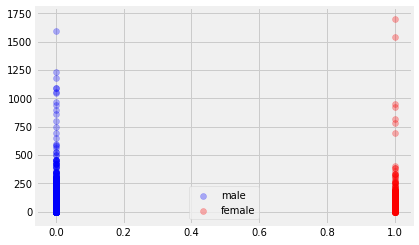

In [6]:
fig, ax = plt.subplots()
ax.scatter(male_x, male_missed, c='b', label='male', alpha=0.3)
ax.scatter(female_x, female_missed, c='r', label='female', alpha=0.3)
ax.legend();

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


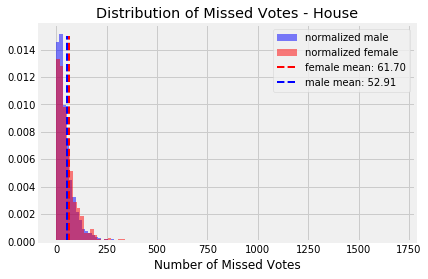

In [7]:
fig, ax = plt.subplots()

female_mean = np.mean(female_missed)
male_mean = np.mean(male_missed)

ax.hist(male_missed, color='b', label='normalized male', bins=100, normed=1, alpha=0.5)
ax.hist(female_missed, color='r', label='normalized female', bins=100, normed=1, alpha=0.5)
ax.vlines(female_mean, 0, 0.015, color='r', linestyle='--', linewidth=2, label='female mean: %.2f' % female_mean)
ax.vlines(male_mean, 0, 0.015, color='b', linestyle='--', linewidth=2, label='male mean: %.2f' % male_mean)
ax.legend()
ax.set_xlabel('Number of Missed Votes');
ax.set_title('Distribution of Missed Votes - House');

In [8]:
print('Male Sample Size: %d' % len(male_missed))
print('Female Sample Size: %d' % len(female_missed))

Male Sample Size: 5598
Female Sample Size: 1007


3. Bootstrapping to justify using a T-test

In [9]:
male_sample_mean = []
female_sample_mean = []

for i in range(10000):
    male_sample = np.random.choice(male_missed, 500)
    female_sample = np.random.choice(female_missed, 500)
    
    male_sample_mean.append(np.mean(male_sample))
    female_sample_mean.append(np.mean(female_sample))

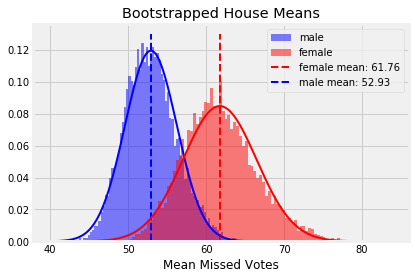

In [10]:
fig, ax = plt.subplots()

male_bootstrapped_mean = np.mean(male_sample_mean)
male_std = np.std(male_sample_mean)
female_bootstrapped_mean = np.mean(female_sample_mean)
female_std = np.std(female_sample_mean)

male_norm = scs.norm(male_bootstrapped_mean, male_std)
female_norm = scs.norm(female_bootstrapped_mean, female_std)


x = np.linspace(40, 80, 500)

ax.hist(male_sample_mean, color='b', label='male', bins=100, alpha=0.5, normed=1)
ax.hist(female_sample_mean, color='r', label='female', bins=100, alpha=0.5, normed=1)
ax.plot(x, male_norm.pdf(x), color='b', linewidth=2)
ax.plot(x, female_norm.pdf(x), color='r', linewidth=2)
ax.vlines(female_bootstrapped_mean, 0, 0.13, color='r', linestyle='--', linewidth=2, label='female mean: %.2f' % female_bootstrapped_mean)
ax.vlines(male_bootstrapped_mean, 0, 0.13, color='b', linestyle='--', linewidth=2, label='male mean: %.2f' % male_bootstrapped_mean)
ax.legend()
ax.set_title('Bootstrapped House Means')
ax.set_xlabel('Mean Missed Votes');

since the bootstrapped means are normal, and the sample sizes are sufficiently large, I can use t-tests to accept or reject my hypothesis.

In [11]:
ttest, p_val = scs.ttest_ind(male_sample_mean, female_sample_mean)
print(p_val)

0.0


4. Running our t-test

In a given session of Congress, female representatives miss 61.68 votes on average, while male representatives miss 52.91 votes on average. The question is, is this significant?

$$H_0: \mu_f = \mu_m$$
$$H_a: \mu_f \neq \mu_m$$

We want to run a 2-tail t-test. Our alpha threshold will be 0.05.

In [12]:
t_stat, p_val = scs.ttest_ind(male_missed, female_missed, equal_var=False)
print(p_val)

0.010819430666834648


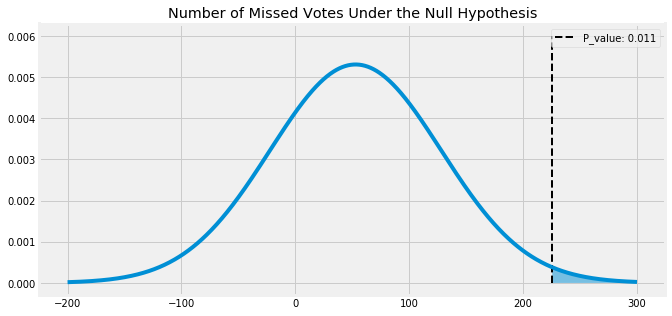

In [13]:
dist_m = scs.norm(np.mean(male_missed), np.std(male_missed))
y = dist_m.ppf(1 - p_val)
fig, ax = plt.subplots(figsize=(10, 5))
x = np.linspace(-200, 300, 1000)
ax.plot(x, dist_m.pdf(x))
ax.vlines(y, 0, 0.006, linestyle='dashed', linewidth=2, label='P_value: %.3f' % p_val)
fill_space = np.linspace(y, 300, 500)
ax.fill_between(fill_space, 0, dist_m.pdf(fill_space), alpha=0.5)
ax.set_title('Number of Missed Votes Under the Null Hypothesis')
ax.legend();

In [14]:
# Removing Speakers
female_reps_no_speaker = female_reps[(female_reps['leadership_role'] != 'Speaker of the House')]['missed_votes']
male_reps_no_speaker = male_reps[(male_reps['leadership_role'] != 'Speaker of the House')]['missed_votes']

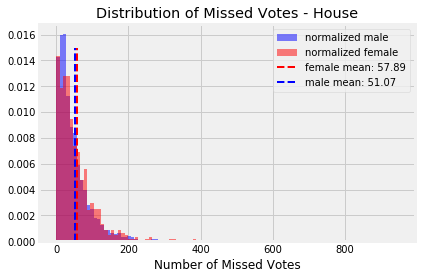

In [15]:
fig, ax = plt.subplots()

female_mean = np.mean(female_reps_no_speaker)
male_mean = np.mean(male_reps_no_speaker)

ax.hist(male_reps_no_speaker, color='b', label='normalized male', bins=100, normed=1, alpha=0.5)
ax.hist(female_reps_no_speaker, color='r', label='normalized female', bins=100, normed=1, alpha=0.5)
ax.vlines(female_mean, 0, 0.015, color='r', linestyle='--', linewidth=2, label='female mean: %.2f' % female_mean)
ax.vlines(male_mean, 0, 0.015, color='b', linestyle='--', linewidth=2, label='male mean: %.2f' % male_mean)
ax.legend()
ax.set_xlabel('Number of Missed Votes');
ax.set_title('Distribution of Missed Votes - House');

In [16]:
t_stat, p_val = scs.ttest_ind(male_reps_no_speaker, female_reps_no_speaker, equal_var=False)
print(p_val)

0.006369230555818956


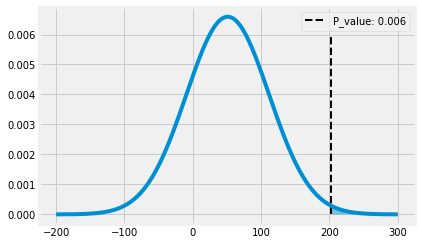

In [17]:
dist_m = scs.norm(np.mean(male_reps_no_speaker), np.std(male_reps_no_speaker))
y = dist_m.ppf(1 - p_val)
fig, ax = plt.subplots()
x = np.linspace(-200, 300, 1000)
ax.plot(x, dist_m.pdf(x))
ax.vlines(y, 0, 0.006, linestyle='dashed', linewidth=2, label='P_value: %.3f' % p_val)
fill_space = np.linspace(y, 300, 500)
ax.fill_between(fill_space, 0, dist_m.pdf(fill_space), alpha=0.5)
ax.legend();

Conclusion: Female reps miss more votes on average than male reps, and it is statistically significant, even when accounting for the Speaker of the House

On average, female representatives miss 61.7 votes per Congressional session while male representatives miss 52.91. While this is a notable difference, I want to see if it is statistically significant. I have 1007 samples for female representatives and 5598 samples for male representatives. The null hypothesis is that the two samples were drawn from the same distribution, and that mean_f = mean_m. The alternative is that they were not drawn from the same distribution, and mean_f > mean_m. Because my samples are large enough, I am able to use a t-test, although I am using a Welsh adjustment to account for the disproportionate size between the two samples. The threshold for rejection is 0.02, since the claim that female representatives miss more votes than male reps carries significant weight.

With a p-value of 0.011 I reject the null hypothesis and can determine that female representatives miss more votes than male representatives and it *is* statistically significant

### Looking at Senate

In [13]:
male_senators = senate[senate['gender'] == 'M']
female_senators = senate[senate['gender'] == 'F']

male_missed = male_senators['missed_votes']
male_x = np.zeros(len(male_missed),)

female_missed = female_senators['missed_votes']
female_x = np.ones(len(female_missed))

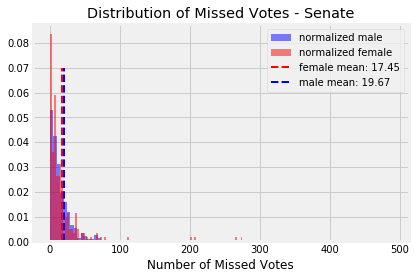

In [14]:
fig, ax = plt.subplots()

female_mean = np.mean(female_missed)
male_mean = np.mean(male_missed)

ax.hist(male_missed, color='b', label='normalized male', bins=100, normed=1, alpha=0.5)
ax.hist(female_missed, color='r', label='normalized female', bins=100, normed=1, alpha=0.5)
ax.vlines(female_mean, 0, 0.07, color='r', linestyle='--', linewidth=2, label='female mean: %.2f' % female_mean)
ax.vlines(male_mean, 0, 0.07, color='b', linestyle='--', linewidth=2, label='male mean: %.2f' % male_mean)
ax.legend()
ax.set_xlabel('Number of Missed Votes')
ax.set_title('Distribution of Missed Votes - Senate');

In a given session of Congress, female senators miss 17.45 votes on average, while male representatives miss 19.67 votes on average. The question is, is this significant?

$$H_0: \mu_f = \mu_m$$
$$H_a: \mu_f > \mu_m$$

We want to run a 2-tail t-test. Our alpha threshold will be 0.05.

In [15]:
t_stat, p_val = scs.ttest_ind(male_missed, female_missed)
print(p_val)

0.3935197322521503


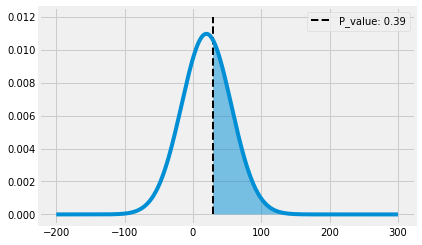

In [16]:
dist_m = scs.norm(np.mean(male_missed), np.std(male_missed))
y = dist_m.ppf(1 - p_val)
fig, ax = plt.subplots()
x = np.linspace(-200, 300, 1000)
ax.plot(x, dist_m.pdf(x))
ax.vlines(y, 0, 0.012, linestyle='dashed', linewidth=2, label='P_value: %.2f' % p_val)

fill_space = np.linspace(y, 300, 500)
ax.fill_between(fill_space, 0, dist_m.pdf(fill_space), alpha=0.5)
ax.legend();

Conclusion: male senators miss more votes than female senators on average, but it is not statistically significant.